# MAlicious APK - Deep Learning Algorithm

by @echavarro

We load the information of our Dataset to watson and save it using a parquet format to use it everytime we need easily.

In [51]:
import ibmos2spark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, StringType

schema = StructType([
        StructField("md5",StringType(),True),
        StructField("detections",FloatType(),True),
        StructField("package",StringType(),True),
        StructField("permissions",StringType(),True),
        StructField("last_date",StringType(),True),
        StructField("verdict",StringType(),True),
        StructField("positives",FloatType(),True)
    ])
import ibmos2spark

credentials = {
    'endpoint': 'https://*********.service.networklayer.com',
    'api_key': '********',
    'service_id': '***********',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_**********_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('androsamples.csv', 'default-donotdelete-pr-rpftkmns4umuhm'),schema=schema)

df=df.repartition(1)

df.write.mode("Overwrite").parquet(cos.url('apk_malicious.parquet', 'default-donotdelete-pr-rpftkmns4umuhm'))

path_gp=cos.url('apk_malicious.parquet', 'default-donotdelete-pr-rpftkmns4umuhm')
df_apk=spark.read.parquet(path_gp)

Our information is now loaded and can be managed in the dataframe df_apk. We confirm the schema of this dataframe and also the content

In [52]:
df_apk.printSchema()

root
 |-- md5: string (nullable = true)
 |-- detections: float (nullable = true)
 |-- package: string (nullable = true)
 |-- permissions: string (nullable = true)
 |-- last_date: string (nullable = true)
 |-- verdict: string (nullable = true)
 |-- positives: float (nullable = true)



In [53]:
df_apk.groupBy('verdict').count().show()

+--------------------+-----+
|             verdict|count|
+--------------------+-----+
|not-a-virus:HEUR:...|    1|
| IM-Worm.Win32.VB.ln|    1|
|HEUR:Trojan-Spy.A...|    1|
|HEUR:Trojan.Andro...|    2|
|HEUR:Trojan.Andro...|    1|
|HEUR:Trojan-SMS.A...|    1|
|Backdoor.AndroidO...|    2|
|HEUR:Trojan-Dropp...|    1|
|not-a-virus:HEUR:...|    1|
|not-a-virus:HEUR:...|    1|
|not-a-virus:HEUR:...|    1|
|HEUR:Backdoor.And...|   98|
|not-a-virus:HEUR:...|    1|
|                None|  371|
|not-a-virus:HEUR:...|    1|
|Virus.Win32.Renam...|   11|
|not-a-virus:HEUR:...|    1|
|Trojan.Win32.Hesv...|    1|
|not-a-virus:HEUR:...|    1|
|not-a-virus:HEUR:...|    1|
+--------------------+-----+
only showing top 20 rows



We transform our data and use matploit to plot the distribution of our data. We can se that, based on the positive value, we have 300 records with 0 positive (it means benign files) and more than 1000 with a 1 positive value (this means Malocious files)

In [54]:
def getListForHistogramAndBoxPlot(df):
    return df.rdd.map(lambda row: row.positives).collect()

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

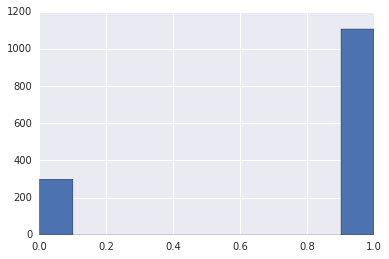

In [56]:
plt.hist(getListForHistogramAndBoxPlot(df_apk))
plt.show()

We can also use seaborn to plot the distributions and validate it for the fields positive (0 for bening and 1 for malicious), detections (number of engines that detect it on VT) and verdicts (number of verdicts for Kaspersky and its distribution)

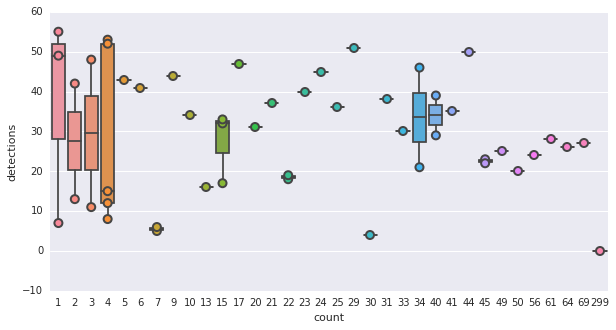

In [57]:
import seaborn as sns
import pandas as pd

def myPlot(field,figsize):
    plt.figure(figsize=figsize)
    values=df_apk.groupBy(field).count().collect()
    tmp = pd.DataFrame(values, columns=[field,'count'])
    sns.boxplot(x='count', y=field, data=tmp)
    sns.stripplot(x='count', y=field, data=tmp, 
              size=8, jitter=False, edgecolor="gray", linewidth=2)
    plt.show()
myPlot('detections',(10,5))

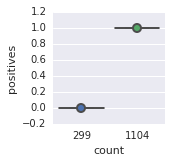

In [58]:
myPlot('positives',(2,2))

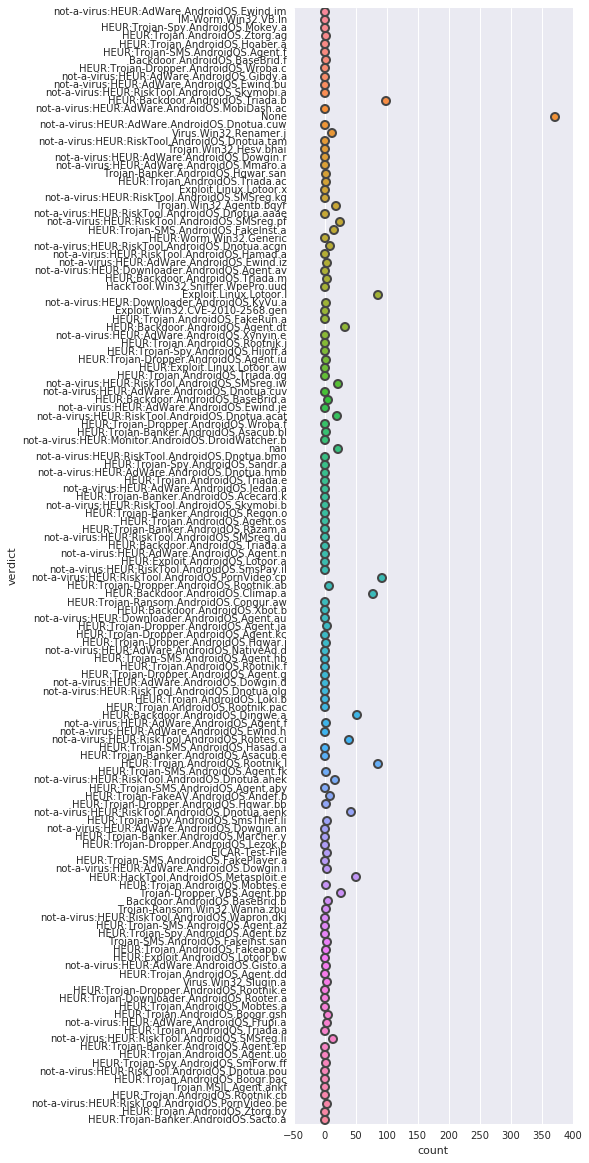

In [59]:
myPlot("verdict",(5,20))

We create an index value (label) for every verdict, this helps the system to improve the job based on numbers instead of strings

In [60]:
from pyspark.ml.feature import StringIndexer

df_apk.createOrReplaceTempView("dfa")
dfa=spark.sql("select md5, positives, permissions, verdict from dfa")

indexer = StringIndexer().setInputCol("verdict").setOutputCol("label")
indexed = indexer.setHandleInvalid("skip").fit(dfa).transform(dfa)
indexed.show()

+--------------------+---------+--------------------+--------------------+-----+
|                 md5|positives|         permissions|             verdict|label|
+--------------------+---------+--------------------+--------------------+-----+
|944850ee0b7fc774c...|      1.0|android.permissio...|not-a-virus:HEUR:...| 85.0|
|f74564454f744262e...|      1.0|android.permissio...|Virus.Win32.Renam...| 20.0|
|727b985e8652db6b9...|      1.0|android.permissio...|Trojan-Ransom.Win...| 52.0|
|021d55c415ff951c8...|      1.0|android.permissio...|HEUR:Trojan-SMS.A...|123.0|
|da0727796e4a6179f...|      1.0|android.permissio...|HEUR:Trojan-Dropp...| 28.0|
|143eb29633856d25a...|      1.0|android.permissio...|                None|  0.0|
|2c7281e235b6ee680...|      1.0|android.permissio...|                 nan| 13.0|
|43bab5987a2a51325...|      1.0|com.android.launc...|Trojan-Dropper.VB...| 11.0|
|7d73c9a6deb18a57a...|      1.0|android.permissio...|not-a-virus:HEUR:...| 81.0|
|25e9c9e73f15d10db...|      

In [18]:
import pip

try:
    __import__('keras')
except ImportError:
    pip.main(['install', 'keras']) 
    
try:
    __import__('h5py')
except ImportError:
    pip.main(['install', 'h5py']) 

Using TensorFlow backend.


Using keras we create our inputs, outputs and our model to train.

We use X as input based in the information from permissions field.

Y is our output and wil describe the kind of file benign or malicious, based in the permissions for each file.

In [61]:
X = indexed.select('permissions').toPandas()
y = indexed.select('positives').toPandas()

CountVectorizer will convert our permissions field in a matrix containing as many columns as permissions exist in the dataset and will marrk wich of those are enabled for each file. 

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X.permissions)
X_train, X_test, y_train, y_test = train_test_split(X_train_counts, y, random_state=1)

Now we have our inputs with a shape o n, number of permissions in the system.

In [63]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1052, 1955)
(351, 1955)
(1052, 1)
(351, 1)


In [64]:
max_perm = X_train.shape[1]

num_classes=indexed.select('Positives').distinct().count()
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Y must be also modified, we have a 1 dimention field but based on the number of classes (two: benign and malicious) it's better use a bidimentional vector for each record, to stablish the probability for each record on each class.

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1052, 1955)
(351, 1955)
(1052, 2)
(351, 2)


In [66]:
from keras.constraints import maxnorm
model = Sequential()
model.add(Dense(512,activation='relu',input_dim=max_perm)) 
model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(32, kernel_initializer='normal', activation='sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dense(num_classes,activation='softmax')) 

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
#This is to avoid memory problems
from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [69]:
batch_size = 64
model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test,y_test))
score = model.evaluate(X_test, y_test, batch_size=batch_size,verbose=1)

Train on 1052 samples, validate on 351 samples
Epoch 1/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.5670 - acc: 0.6787 - val_loss: 0.4832 - val_acc: 0.7892
Epoch 2/50
1052/1052 [==============================] - 0s 257us/step - loss: 0.4442 - acc: 0.7947 - val_loss: 0.3779 - val_acc: 0.8376
Epoch 3/50
1052/1052 [==============================] - 0s 290us/step - loss: 0.3402 - acc: 0.8574 - val_loss: 0.2985 - val_acc: 0.8689
Epoch 4/50
1052/1052 [==============================] - 0s 287us/step - loss: 0.2866 - acc: 0.8821 - val_loss: 0.2456 - val_acc: 0.9288
Epoch 5/50
1052/1052 [==============================] - 0s 338us/step - loss: 0.2278 - acc: 0.9297 - val_loss: 0.1988 - val_acc: 0.9316
Epoch 6/50
1052/1052 [==============================] - 0s 285us/step - loss: 0.1790 - acc: 0.9392 - val_loss: 0.1782 - val_acc: 0.9544
Epoch 7/50
1052/1052 [==============================] - 0s 288us/step - loss: 0.1546 - acc: 0.9525 - val_loss: 0.1631 - val_acc: 0.9601
Epo

Once our model finishes training, we have an accuracy over 90%, a good score for the system.

In [70]:
score[1]

0.9430199431897568

In [71]:
#!mkdir malapk
!rm malapk/malapk_DL.h5
model.save("malapk/malapk_DL.h5")

In [72]:
from keras.models import load_model
model_sv=load_model("malapk/malapk_DL.h5")
model_sv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1001472   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 1,036,450
Trainable params: 1,036,450
Non-trainable params: 0
_________________________________________________________________


We use our model to predict the values for the imputs saved on X_test. These values are obtained using the predict function for the model. We plot bot results, the y_pred_class and the original y_test, we can see both plots are similar so our system is very accurated.

In [73]:
y_pred_class = model_sv.predict(X_test)

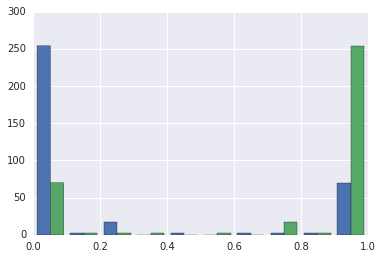

In [74]:
plt.hist(y_pred_class)
plt.show()

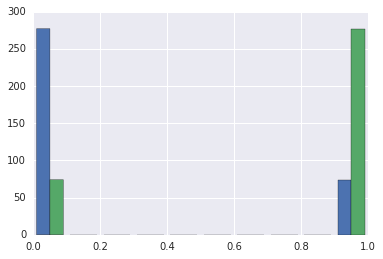

In [75]:
plt.hist(y_test)
plt.show()

Using the model, we create a my_evaluate function that predicts the results based on the permissions of an apk, we test it with a random value from our dataset and confirm the result

In [76]:
def my_evaluate(permissions,model, count_vect):
    status=["Benign  ", "Malicious"]
    res=model.predict(count_vect.transform([permissions]))[0].tolist()
    for i in range(0,2):
        print status[i],"\t",res[i]*100,"%"

    print '_____________________________'

In [77]:
permissions='    com.llamalab.automate.permission.C2D_MESSAGE android.permission.WAKE_LOCK android.permission.RECEIVE_BOOT_COMPLETED com.android.launcher.permission.INSTALL_SHORTCUT android.permission.VIBRATE android.permission.AUTHENTICATE_ACCOUNTS android.permission.GET_ACCOUNTS com.android.vending.BILLING com.google.android.providers.gsf.permission.READ_GSERVICES android.permission.BIND_ACCESSIBILITY_SERVICE android.permission.BIND_NOTIFICATION_LISTENER_SERVICE cyanogenmod.permission.PUBLISH_CUSTOM_TILE android.permission.PACKAGE_USAGE_STATS'
my_evaluate(permissions, model_sv,count_vect)

Benign   	99.781358242 %
Malicious 	0.218643550761 %
_____________________________


Now let's move to verdict as the output y besides the positive value. We start by loading again the information from the original datset and spliting it into test and train. We use the field label that corresponds to the index for every verdict in the system.

Now y doesn't have 2 dimmentions but as many as lables in the sytem, in this case 130.

In [81]:
yv = indexed.select('label').toPandas()

count_vect2 = CountVectorizer()
Xv_train_counts = count_vect2.fit_transform(X.permissions)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv_train_counts, yv, random_state=1)

In [82]:
max_perm = Xv_train.shape[1]

num_classes=indexed.select('label').distinct().count()
yv_train = to_categorical(yv_train, num_classes)
yv_test = to_categorical(yv_test, num_classes)

In [83]:
print(Xv_train.shape)
print(Xv_test.shape)
print(yv_train.shape)
print(yv_test.shape)

(1052, 1955)
(351, 1955)
(1052, 138)
(351, 138)


In [97]:
modelv = Sequential()
modelv.add(Dense(2048,activation='relu',input_dim=max_perm)) 
modelv.add(Dropout(0.2))
modelv.add(Dense(512, kernel_initializer='normal', activation='sigmoid', kernel_constraint=maxnorm(3)))
modelv.add(Dense(256,activation='relu')) 
modelv.add(Dense(num_classes,activation='softmax')) 

In [98]:
modelv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
batch_size = 64
modelv.fit(Xv_train, yv_train, batch_size=batch_size, epochs=50, validation_data=(Xv_test,yv_test))
score = modelv.evaluate(Xv_test, yv_test, batch_size=batch_size,verbose=1)

Train on 1052 samples, validate on 351 samples
Epoch 1/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.6850 - acc: 0.8184 - val_loss: 1.4876 - val_acc: 0.7721
Epoch 2/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.6285 - acc: 0.8232 - val_loss: 1.4994 - val_acc: 0.7607
Epoch 3/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.5563 - acc: 0.8356 - val_loss: 1.4956 - val_acc: 0.7835
Epoch 4/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.5095 - acc: 0.8565 - val_loss: 1.5062 - val_acc: 0.7835
Epoch 5/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.4621 - acc: 0.8669 - val_loss: 1.5209 - val_acc: 0.7664
Epoch 6/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.4153 - acc: 0.8802 - val_loss: 1.5304 - val_acc: 0.7920
Epoch 7/50
1052/1052 [==============================] - 2s 2ms/step - loss: 0.3793 - acc: 0.8926 - val_loss: 1.5855 - val_acc: 0.8120
Epoch 8/50
1052

In [101]:
score[1]

0.7977207956830321

We train the system and see that the acurracy moves down to 79%, not a bad score but maybe we can improve it next time.

In [106]:
!rm malapk/malapkv_DL.h5
modelv.save("malapk/malapkv_DL.h5")

In [107]:
model_svv=load_model("malapk/malapkv_DL.h5")
model_svv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2048)              4005888   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_22 (Dense)             (None, 138)               35466     
Total params: 5,221,770
Trainable params: 5,221,770
Non-trainable params: 0
_________________________________________________________________


Using this new model, we predict the valuse for yv_pred_class, plot it and compare it to the original yv_test information. Again it is quite similar.

In [108]:
yv_pred_class = model_svv.predict(Xv_test)

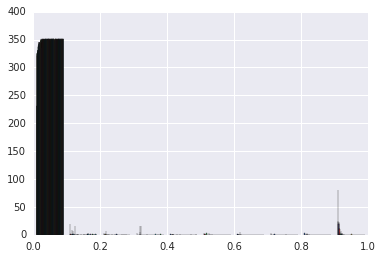

In [109]:
plt.hist(yv_pred_class)
plt.show()

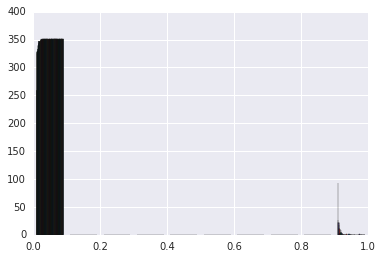

In [110]:
plt.hist(yv_test)
plt.show()

We create the my_evaluatev function to predict the verdict based on the permissions given. We use a random value from the dataset and confirm that the predicted value is the same as in the dataset.

In [170]:
def my_evaluatev(permissions,model, count_vect):
    res=model.predict(count_vect.transform([permissions]))[0].tolist()
    best=0
    best_index=0
    for i in range(0,num_classes):
        if res[i] > best:
            best=res[i]
            best_index=i
    print indexed.filter(indexed['label'] == best_index).first()['verdict'],":\t",best*100,"%"

    print '_____________________________'

In [172]:
permissions='android.permission.SYSTEM_ALERT_WINDOW android.permission.RECEIVE_BOOT_COMPLETED android.permission.SET_WALLPAPER android.permission.INTERNET android.permission.ACCESS_WIFI_STATE android.permission.ACCESS_NETWORK_STATE android.permission.READ_EXTERNAL_STORAGE android.permission.WRITE_EXTERNAL_STORAGE android.permission.CHANGE_NETWORK_STATE android.permission.CHANGE_WIFI_STATE'
my_evaluatev(permissions, model_svv,count_vect2)

Trojan-Ransom.Win32.Wanna.zbu :	99.0238785744 %
_____________________________
